In [1]:
from lib_linear import *
import  time
import torch.nn.functional as F

input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix


## Data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

## Neural network model

In [3]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        
        self.D = len(layers_dim)-1
        assert self.D == D
        
        print("Depth of the network = number of hidden layers + 1:", D)
        
        for i in range(self.D):
            
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            
            stdv = 2/ np.sqrt(layers_dim[i])
            
            weight = (weight-0.5)*stdv

            weight.requires_grad = True
            
            self.weights.append(weight)
       
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [4]:
input_dim = 784
output_dim = 10
hidden_dim1 = 500

D = 2

# initialize the model
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

Depth of the network = number of hidden layers + 1: 2


## Training parameters

In [5]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

## Training loop

In [6]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []
MSE_tab = []
R_tab = []

In [7]:
batch_size: int = 1000 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        # reset the gradients from previouis iteration
        optimizer.zero_grad()

        # pass through the network
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)

        # backward pass thorught the network
        loss.backward()

        # apply the gradients
        optimizer.step()     

    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )

    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())


    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            # pass through the network            
            output: torch.Tensor = model(x)
            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))

        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            # pass through the network            
            output: torch.Tensor = model(x)

            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))

    ########################################################################
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]

    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
    
    term_I_tab.append(term_1)
    term_II_tab.append(term_2)
    term_IV_tab.append(term_4)
    R_tab.append(R)

    term_1 = round(float(term_1), 6)
    term_2 = round(term_2, 6)

    check = round(1+ term_2 - term_4, 6)
    check2 = round(1+ term_1 + term_2 - term_4, 6)

    print(f"{e}\t{loss} \t term1: {term_1}, \t term2: {term_2} \t {check}\t {check2}")   



0	0.09409652650356293 	 term1: 0.103478, 	 term2: 0.373427 	 1.108051	 1.211529
1	0.07580511271953583 	 term1: 0.042002, 	 term2: 0.282765 	 0.905313	 0.947315
2	0.06691265106201172 	 term1: 0.020451, 	 term2: 0.238971 	 0.794616	 0.815067
3	0.0614483468234539 	 term1: 0.011165, 	 term2: 0.213015 	 0.724863	 0.736028
4	0.057733215391635895 	 term1: 0.007053, 	 term2: 0.196101 	 0.676441	 0.683494
5	0.055046502500772476 	 term1: 0.005438, 	 term2: 0.184406 	 0.640674	 0.646112
6	0.053013525903224945 	 term1: 0.005095, 	 term2: 0.175966 	 0.613151	 0.618246
7	0.05141960456967354 	 term1: 0.005407, 	 term2: 0.169672 	 0.591351	 0.596758
8	0.05013366416096687 	 term1: 0.006048, 	 term2: 0.164851 	 0.573695	 0.579743
9	0.04907168447971344 	 term1: 0.006843, 	 term2: 0.161077 	 0.559132	 0.565975
10	0.048177555203437805 	 term1: 0.007697, 	 term2: 0.158067 	 0.546932	 0.554629
11	0.047412481158971786 	 term1: 0.008557, 	 term2: 0.155628 	 0.536571	 0.545128
12	0.04674882814288139 	 term1: 0.

102	0.03717171028256416 	 term1: 0.030295, 	 term2: 0.14269 	 0.412253	 0.442548
103	0.03714726120233536 	 term1: 0.030376, 	 term2: 0.14274 	 0.411996	 0.442372
104	0.03712315857410431 	 term1: 0.030456, 	 term2: 0.142791 	 0.411743	 0.442199
105	0.03709939494729042 	 term1: 0.030535, 	 term2: 0.142842 	 0.411494	 0.442029
106	0.03707597777247429 	 term1: 0.030614, 	 term2: 0.142893 	 0.411248	 0.441862
107	0.037052884697914124 	 term1: 0.030691, 	 term2: 0.142945 	 0.411008	 0.441699
108	0.03703010454773903 	 term1: 0.030767, 	 term2: 0.142996 	 0.41077	 0.441537
109	0.0370076484978199 	 term1: 0.030843, 	 term2: 0.143047 	 0.410535	 0.441378
110	0.03698549047112465 	 term1: 0.030918, 	 term2: 0.143098 	 0.410304	 0.441222
111	0.036963630467653275 	 term1: 0.030992, 	 term2: 0.143149 	 0.410077	 0.441069
112	0.03694206476211548 	 term1: 0.031065, 	 term2: 0.1432 	 0.409853	 0.440918
113	0.036920782178640366 	 term1: 0.031137, 	 term2: 0.143252 	 0.409633	 0.44077
114	0.03689978271722

203	0.03570820391178131 	 term1: 0.03563, 	 term2: 0.147488 	 0.397619	 0.433249
204	0.035699512809515 	 term1: 0.035666, 	 term2: 0.14753 	 0.397538	 0.433204
205	0.03569088876247406 	 term1: 0.0357, 	 term2: 0.147571 	 0.397458	 0.433158
206	0.0356823168694973 	 term1: 0.035735, 	 term2: 0.147612 	 0.397378	 0.433113
207	0.035673823207616806 	 term1: 0.03577, 	 term2: 0.147653 	 0.397298	 0.433068
208	0.03566538542509079 	 term1: 0.035804, 	 term2: 0.147694 	 0.39722	 0.433024
209	0.03565701097249985 	 term1: 0.035838, 	 term2: 0.147734 	 0.397141	 0.432979
210	0.03564869612455368 	 term1: 0.035872, 	 term2: 0.147775 	 0.397064	 0.432936
211	0.035640452057123184 	 term1: 0.035905, 	 term2: 0.147815 	 0.396987	 0.432892
212	0.03563225641846657 	 term1: 0.035939, 	 term2: 0.147856 	 0.396912	 0.432851
213	0.035624124109745026 	 term1: 0.035972, 	 term2: 0.147896 	 0.396836	 0.432808
214	0.035616058856248856 	 term1: 0.036005, 	 term2: 0.147936 	 0.396761	 0.432766
215	0.035608045756816

304	0.03506939113140106 	 term1: 0.038338, 	 term2: 0.151064 	 0.391871	 0.430209
305	0.035064809024333954 	 term1: 0.038359, 	 term2: 0.151094 	 0.391831	 0.43019
306	0.035060249269008636 	 term1: 0.038379, 	 term2: 0.151124 	 0.391792	 0.430171
307	0.03505571931600571 	 term1: 0.038399, 	 term2: 0.151153 	 0.391752	 0.430151
308	0.03505120798945427 	 term1: 0.038419, 	 term2: 0.151183 	 0.391714	 0.430133
309	0.03504671901464462 	 term1: 0.03844, 	 term2: 0.151213 	 0.391676	 0.430116
310	0.035042259842157364 	 term1: 0.038459, 	 term2: 0.151242 	 0.391637	 0.430096
311	0.0350378192961216 	 term1: 0.038479, 	 term2: 0.151272 	 0.391599	 0.430078
312	0.03503340855240822 	 term1: 0.038499, 	 term2: 0.151301 	 0.391561	 0.43006
313	0.03502901270985603 	 term1: 0.038519, 	 term2: 0.15133 	 0.391523	 0.430042
314	0.03502463921904564 	 term1: 0.038539, 	 term2: 0.15136 	 0.391487	 0.430026
315	0.03502029553055763 	 term1: 0.038558, 	 term2: 0.151389 	 0.391449	 0.430007
316	0.0350159741938

405	0.034704722464084625 	 term1: 0.040021, 	 term2: 0.153682 	 0.388815	 0.428836
406	0.034701891243457794 	 term1: 0.040034, 	 term2: 0.153704 	 0.388792	 0.428826
407	0.03469907492399216 	 term1: 0.040048, 	 term2: 0.153726 	 0.388769	 0.428817
408	0.034696269780397415 	 term1: 0.040061, 	 term2: 0.153749 	 0.388747	 0.428808
409	0.03469347953796387 	 term1: 0.040075, 	 term2: 0.153771 	 0.388724	 0.428799
410	0.034690696746110916 	 term1: 0.040088, 	 term2: 0.153793 	 0.388701	 0.428789
411	0.03468792885541916 	 term1: 0.040101, 	 term2: 0.153815 	 0.388679	 0.42878
412	0.0346851721405983 	 term1: 0.040114, 	 term2: 0.153837 	 0.388656	 0.42877
413	0.03468242287635803 	 term1: 0.040128, 	 term2: 0.153858 	 0.388633	 0.428761
414	0.03467969223856926 	 term1: 0.040141, 	 term2: 0.15388 	 0.388611	 0.428752
415	0.03467697277665138 	 term1: 0.040154, 	 term2: 0.153902 	 0.388589	 0.428743
416	0.034674257040023804 	 term1: 0.040167, 	 term2: 0.153924 	 0.388568	 0.428735
417	0.034671559

506	0.03446957841515541 	 term1: 0.041176, 	 term2: 0.155655 	 0.386933	 0.428109
507	0.0344676710665226 	 term1: 0.041186, 	 term2: 0.155672 	 0.386918	 0.428104
508	0.03446577861905098 	 term1: 0.041196, 	 term2: 0.155689 	 0.386903	 0.428099
509	0.03446388617157936 	 term1: 0.041205, 	 term2: 0.155706 	 0.386889	 0.428094
510	0.03446200117468834 	 term1: 0.041215, 	 term2: 0.155723 	 0.386874	 0.428089
511	0.034460119903087616 	 term1: 0.041224, 	 term2: 0.15574 	 0.386859	 0.428083
512	0.03445825353264809 	 term1: 0.041234, 	 term2: 0.155757 	 0.386845	 0.428079
513	0.03445638343691826 	 term1: 0.041243, 	 term2: 0.155774 	 0.38683	 0.428073
514	0.034454524517059326 	 term1: 0.041253, 	 term2: 0.155791 	 0.386816	 0.428069
515	0.03445267304778099 	 term1: 0.041262, 	 term2: 0.155807 	 0.386801	 0.428063
516	0.03445082902908325 	 term1: 0.041272, 	 term2: 0.155824 	 0.386786	 0.428058
517	0.03444898501038551 	 term1: 0.041281, 	 term2: 0.155841 	 0.386772	 0.428053
518	0.03444715589

607	0.03430661931633949 	 term1: 0.042022, 	 term2: 0.157186 	 0.385664	 0.427686
608	0.034305259585380554 	 term1: 0.042029, 	 term2: 0.1572 	 0.385654	 0.427683
609	0.03430390730500221 	 term1: 0.042036, 	 term2: 0.157213 	 0.385644	 0.42768
610	0.03430255502462387 	 term1: 0.042044, 	 term2: 0.157227 	 0.385634	 0.427678
611	0.034301210194826126 	 term1: 0.042051, 	 term2: 0.15724 	 0.385623	 0.427674
612	0.03429986536502838 	 term1: 0.042058, 	 term2: 0.157253 	 0.385612	 0.42767
613	0.034298527985811234 	 term1: 0.042065, 	 term2: 0.157266 	 0.385602	 0.427667
614	0.034297190606594086 	 term1: 0.042072, 	 term2: 0.15728 	 0.385592	 0.427664
615	0.03429586440324783 	 term1: 0.042079, 	 term2: 0.157293 	 0.385582	 0.427661
616	0.03429453819990158 	 term1: 0.042086, 	 term2: 0.157306 	 0.385571	 0.427657
617	0.034293219447135925 	 term1: 0.042093, 	 term2: 0.157319 	 0.385561	 0.427654
618	0.03429189696907997 	 term1: 0.0421, 	 term2: 0.157332 	 0.385551	 0.427651
619	0.0342905856668

708	0.03418807312846184 	 term1: 0.042668, 	 term2: 0.158404 	 0.384753	 0.427421
709	0.034187063574790955 	 term1: 0.042673, 	 term2: 0.158415 	 0.384745	 0.427418
710	0.03418605774641037 	 term1: 0.042679, 	 term2: 0.158426 	 0.384738	 0.427417
711	0.03418505936861038 	 term1: 0.042685, 	 term2: 0.158436 	 0.384729	 0.427414
712	0.034184057265520096 	 term1: 0.04269, 	 term2: 0.158447 	 0.384722	 0.427412
713	0.03418305888772011 	 term1: 0.042696, 	 term2: 0.158458 	 0.384714	 0.42741
714	0.03418206796050072 	 term1: 0.042701, 	 term2: 0.158469 	 0.384707	 0.427408
715	0.03418107330799103 	 term1: 0.042707, 	 term2: 0.158479 	 0.384699	 0.427406
716	0.034180086106061935 	 term1: 0.042713, 	 term2: 0.15849 	 0.384691	 0.427404
717	0.03417909890413284 	 term1: 0.042718, 	 term2: 0.1585 	 0.384683	 0.427401
718	0.03417811170220375 	 term1: 0.042724, 	 term2: 0.158511 	 0.384676	 0.4274
719	0.034177131950855255 	 term1: 0.042729, 	 term2: 0.158522 	 0.384669	 0.427398
720	0.0341761521995

808	0.03409953415393829 	 term1: 0.043173, 	 term2: 0.159384 	 0.384072	 0.427245
809	0.03409876301884651 	 term1: 0.043178, 	 term2: 0.159393 	 0.384066	 0.427244
810	0.03409798815846443 	 term1: 0.043182, 	 term2: 0.159402 	 0.38406	 0.427242
811	0.03409722074866295 	 term1: 0.043187, 	 term2: 0.15941 	 0.384053	 0.42724
812	0.034096453338861465 	 term1: 0.043191, 	 term2: 0.159419 	 0.384048	 0.427239
813	0.03409568965435028 	 term1: 0.043195, 	 term2: 0.159428 	 0.384042	 0.427237
814	0.034094925969839096 	 term1: 0.0432, 	 term2: 0.159437 	 0.384036	 0.427236
815	0.03409415856003761 	 term1: 0.043204, 	 term2: 0.159446 	 0.384031	 0.427235
816	0.034093402326107025 	 term1: 0.043209, 	 term2: 0.159454 	 0.384024	 0.427233
817	0.03409264609217644 	 term1: 0.043213, 	 term2: 0.159463 	 0.384018	 0.427231
818	0.03409188613295555 	 term1: 0.043218, 	 term2: 0.159472 	 0.384013	 0.427231
819	0.03409112989902496 	 term1: 0.043222, 	 term2: 0.159481 	 0.384007	 0.427229
820	0.034090377390

909	0.034030236303806305 	 term1: 0.043586, 	 term2: 0.160202 	 0.383534	 0.42712
910	0.034029629081487656 	 term1: 0.04359, 	 term2: 0.16021 	 0.38353	 0.42712
911	0.0340290293097496 	 term1: 0.043594, 	 term2: 0.160217 	 0.383525	 0.427119
912	0.034028422087430954 	 term1: 0.043597, 	 term2: 0.160224 	 0.38352	 0.427117
913	0.0340278185904026 	 term1: 0.043601, 	 term2: 0.160232 	 0.383516	 0.427117
914	0.03402721881866455 	 term1: 0.043605, 	 term2: 0.160239 	 0.383511	 0.427116
915	0.0340266190469265 	 term1: 0.043608, 	 term2: 0.160246 	 0.383506	 0.427114
916	0.03402602672576904 	 term1: 0.043612, 	 term2: 0.160254 	 0.383502	 0.427114
917	0.03402542695403099 	 term1: 0.043616, 	 term2: 0.160261 	 0.383497	 0.427113
918	0.034024834632873535 	 term1: 0.043619, 	 term2: 0.160268 	 0.383492	 0.427111
919	0.03402423858642578 	 term1: 0.043623, 	 term2: 0.160276 	 0.383488	 0.427111
920	0.034023646265268326 	 term1: 0.043626, 	 term2: 0.160283 	 0.383483	 0.427109
921	0.03402305394411

1010	0.03397541493177414 	 term1: 0.043927, 	 term2: 0.160889 	 0.383103	 0.42703
1011	0.03397493436932564 	 term1: 0.04393, 	 term2: 0.160895 	 0.383099	 0.427029
1012	0.03397444635629654 	 term1: 0.043933, 	 term2: 0.160901 	 0.383095	 0.427028
1013	0.03397396206855774 	 term1: 0.043936, 	 term2: 0.160907 	 0.383091	 0.427027
1014	0.03397348150610924 	 term1: 0.043939, 	 term2: 0.160914 	 0.383088	 0.427027
1015	0.033973000943660736 	 term1: 0.043942, 	 term2: 0.16092 	 0.383084	 0.427026
1016	0.033972520381212234 	 term1: 0.043945, 	 term2: 0.160926 	 0.38308	 0.427025
1017	0.03397203981876373 	 term1: 0.043949, 	 term2: 0.160932 	 0.383076	 0.427025
1018	0.03397157043218613 	 term1: 0.043952, 	 term2: 0.160938 	 0.383072	 0.427024
1019	0.033971089869737625 	 term1: 0.043955, 	 term2: 0.160944 	 0.383068	 0.427023
1020	0.03397061303257942 	 term1: 0.043958, 	 term2: 0.160951 	 0.383065	 0.427023
1021	0.03397013992071152 	 term1: 0.043961, 	 term2: 0.160957 	 0.383061	 0.427022
1022	

1110	0.03393165022134781 	 term1: 0.044211, 	 term2: 0.161466 	 0.382751	 0.426962
1111	0.03393125534057617 	 term1: 0.044213, 	 term2: 0.161472 	 0.382748	 0.426961
1112	0.03393086418509483 	 term1: 0.044216, 	 term2: 0.161477 	 0.382745	 0.426961
1113	0.033930469304323196 	 term1: 0.044218, 	 term2: 0.161482 	 0.382741	 0.426959
1114	0.03393007442355156 	 term1: 0.044221, 	 term2: 0.161488 	 0.382739	 0.42696
1115	0.03392968326807022 	 term1: 0.044224, 	 term2: 0.161493 	 0.382735	 0.426959
1116	0.03392929583787918 	 term1: 0.044226, 	 term2: 0.161498 	 0.382732	 0.426958
1117	0.03392890468239784 	 term1: 0.044229, 	 term2: 0.161504 	 0.382729	 0.426958
1118	0.0339285172522068 	 term1: 0.044231, 	 term2: 0.161509 	 0.382726	 0.426957
1119	0.03392812982201576 	 term1: 0.044234, 	 term2: 0.161514 	 0.382722	 0.426956
1120	0.03392774239182472 	 term1: 0.044236, 	 term2: 0.16152 	 0.38272	 0.426956
1121	0.03392735496163368 	 term1: 0.044239, 	 term2: 0.161525 	 0.382716	 0.426955
1122	0.

1209	0.03389611095190048 	 term1: 0.04445, 	 term2: 0.161959 	 0.382459	 0.426909
1210	0.033895786851644516 	 term1: 0.044452, 	 term2: 0.161964 	 0.382457	 0.426909
1211	0.03389546275138855 	 term1: 0.044454, 	 term2: 0.161968 	 0.382453	 0.426907
1212	0.03389514237642288 	 term1: 0.044457, 	 term2: 0.161973 	 0.382451	 0.426908
1213	0.03389481082558632 	 term1: 0.044459, 	 term2: 0.161978 	 0.382449	 0.426908
1214	0.03389449045062065 	 term1: 0.044461, 	 term2: 0.161982 	 0.382445	 0.426906
1215	0.033894166350364685 	 term1: 0.044463, 	 term2: 0.161987 	 0.382443	 0.426906
1216	0.03389384597539902 	 term1: 0.044466, 	 term2: 0.161992 	 0.382441	 0.426907
1217	0.03389352187514305 	 term1: 0.044468, 	 term2: 0.161996 	 0.382438	 0.426906
1218	0.03389320522546768 	 term1: 0.04447, 	 term2: 0.162001 	 0.382435	 0.426905
1219	0.033892881125211716 	 term1: 0.044472, 	 term2: 0.162005 	 0.382432	 0.426904
1220	0.03389256075024605 	 term1: 0.044474, 	 term2: 0.16201 	 0.38243	 0.426904
1221	

1308	0.03386655077338219 	 term1: 0.044657, 	 term2: 0.162388 	 0.38221	 0.426867
1309	0.0338662788271904 	 term1: 0.044659, 	 term2: 0.162392 	 0.382207	 0.426866
1310	0.03386600688099861 	 term1: 0.044661, 	 term2: 0.162397 	 0.382206	 0.426867
1311	0.033865734934806824 	 term1: 0.044662, 	 term2: 0.162401 	 0.382204	 0.426866
1312	0.03386545926332474 	 term1: 0.044664, 	 term2: 0.162405 	 0.382201	 0.426865
1313	0.03386519104242325 	 term1: 0.044666, 	 term2: 0.162409 	 0.382199	 0.426865
1314	0.03386492654681206 	 term1: 0.044668, 	 term2: 0.162413 	 0.382197	 0.426865
1315	0.03386465460062027 	 term1: 0.04467, 	 term2: 0.162417 	 0.382194	 0.426864
1316	0.03386438265442848 	 term1: 0.044672, 	 term2: 0.162421 	 0.382192	 0.426864
1317	0.03386411443352699 	 term1: 0.044674, 	 term2: 0.162425 	 0.38219	 0.426864
1318	0.0338638499379158 	 term1: 0.044676, 	 term2: 0.162429 	 0.382187	 0.426863
1319	0.033863574266433716 	 term1: 0.044678, 	 term2: 0.162433 	 0.382185	 0.426863
1320	0.

1407	0.03384169191122055 	 term1: 0.044837, 	 term2: 0.162765 	 0.381994	 0.426831
1408	0.03384145349264145 	 term1: 0.044839, 	 term2: 0.162769 	 0.381993	 0.426832
1409	0.033841222524642944 	 term1: 0.04484, 	 term2: 0.162773 	 0.381991	 0.426831
1410	0.03384099528193474 	 term1: 0.044842, 	 term2: 0.162776 	 0.381989	 0.426831
1411	0.03384076803922653 	 term1: 0.044844, 	 term2: 0.16278 	 0.381987	 0.426831
1412	0.033840540796518326 	 term1: 0.044846, 	 term2: 0.162783 	 0.381984	 0.42683
1413	0.03384030982851982 	 term1: 0.044847, 	 term2: 0.162787 	 0.381983	 0.42683
1414	0.033840082585811615 	 term1: 0.044849, 	 term2: 0.16279 	 0.38198	 0.426829
1415	0.03383985161781311 	 term1: 0.044851, 	 term2: 0.162794 	 0.381979	 0.42683
1416	0.033839620649814606 	 term1: 0.044852, 	 term2: 0.162797 	 0.381976	 0.426828
1417	0.0338393971323967 	 term1: 0.044854, 	 term2: 0.162801 	 0.381975	 0.426829
1418	0.03383916616439819 	 term1: 0.044856, 	 term2: 0.162804 	 0.381972	 0.426828
1419	0.0

1506	0.03382055088877678 	 term1: 0.044996, 	 term2: 0.163099 	 0.381806	 0.426802
1507	0.03382035344839096 	 term1: 0.044997, 	 term2: 0.163102 	 0.381804	 0.426801
1508	0.033820152282714844 	 term1: 0.044999, 	 term2: 0.163106 	 0.381803	 0.426802
1509	0.033819954842329025 	 term1: 0.045, 	 term2: 0.163109 	 0.381801	 0.426801
1510	0.033819761127233505 	 term1: 0.045002, 	 term2: 0.163112 	 0.3818	 0.426802
1511	0.033819567412137985 	 term1: 0.045003, 	 term2: 0.163115 	 0.381798	 0.426801
1512	0.033819373697042465 	 term1: 0.045005, 	 term2: 0.163118 	 0.381796	 0.426801
1513	0.03381917625665665 	 term1: 0.045006, 	 term2: 0.163121 	 0.381794	 0.4268
1514	0.03381898254156113 	 term1: 0.045008, 	 term2: 0.163125 	 0.381793	 0.426801
1515	0.03381878510117531 	 term1: 0.045009, 	 term2: 0.163128 	 0.381791	 0.4268
1516	0.03381859138607979 	 term1: 0.045011, 	 term2: 0.163131 	 0.381789	 0.4268
1517	0.03381839767098427 	 term1: 0.045012, 	 term2: 0.163134 	 0.381787	 0.426799
1518	0.033

1606	0.03380225971341133 	 term1: 0.045138, 	 term2: 0.1634 	 0.381639	 0.426777
1607	0.0338020846247673 	 term1: 0.04514, 	 term2: 0.163403 	 0.381637	 0.426777
1608	0.03380191698670387 	 term1: 0.045141, 	 term2: 0.163406 	 0.381636	 0.426777
1609	0.03380174562335014 	 term1: 0.045142, 	 term2: 0.163409 	 0.381635	 0.426777
1610	0.03380157798528671 	 term1: 0.045144, 	 term2: 0.163411 	 0.381632	 0.426776
1611	0.03380141034722328 	 term1: 0.045145, 	 term2: 0.163414 	 0.381631	 0.426776
1612	0.03380123898386955 	 term1: 0.045146, 	 term2: 0.163417 	 0.381629	 0.426775
1613	0.03380107507109642 	 term1: 0.045148, 	 term2: 0.16342 	 0.381628	 0.426776
1614	0.03380090743303299 	 term1: 0.045149, 	 term2: 0.163423 	 0.381627	 0.426776
1615	0.03380073979496956 	 term1: 0.04515, 	 term2: 0.163426 	 0.381625	 0.426775
1616	0.03380056843161583 	 term1: 0.045152, 	 term2: 0.163428 	 0.381623	 0.426775
1617	0.0338004045188427 	 term1: 0.045153, 	 term2: 0.163431 	 0.381622	 0.426775
1618	0.0338

1706	0.03378644213080406 	 term1: 0.045265, 	 term2: 0.16367 	 0.38149	 0.426755
1707	0.03378629684448242 	 term1: 0.045267, 	 term2: 0.163673 	 0.381489	 0.426756
1708	0.03378614783287048 	 term1: 0.045268, 	 term2: 0.163675 	 0.381487	 0.426755
1709	0.03378600627183914 	 term1: 0.045269, 	 term2: 0.163678 	 0.381486	 0.426755
1710	0.0337858572602272 	 term1: 0.04527, 	 term2: 0.16368 	 0.381484	 0.426754
1711	0.033785708248615265 	 term1: 0.045271, 	 term2: 0.163683 	 0.381483	 0.426754
1712	0.03378556668758392 	 term1: 0.045273, 	 term2: 0.163685 	 0.381481	 0.426754
1713	0.033785417675971985 	 term1: 0.045274, 	 term2: 0.163688 	 0.38148	 0.426754
1714	0.033785272389650345 	 term1: 0.045275, 	 term2: 0.16369 	 0.381478	 0.426753
1715	0.033785130828619 	 term1: 0.045276, 	 term2: 0.163693 	 0.381477	 0.426753
1716	0.033784981817007065 	 term1: 0.045277, 	 term2: 0.163695 	 0.381476	 0.426753
1717	0.03378484025597572 	 term1: 0.045279, 	 term2: 0.163698 	 0.381475	 0.426754
1718	0.03

1806	0.033772677183151245 	 term1: 0.04538, 	 term2: 0.163914 	 0.381357	 0.426737
1807	0.033772554248571396 	 term1: 0.045381, 	 term2: 0.163916 	 0.381355	 0.426736
1808	0.03377242386341095 	 term1: 0.045382, 	 term2: 0.163918 	 0.381354	 0.426736
1809	0.033772293478250504 	 term1: 0.045383, 	 term2: 0.163921 	 0.381353	 0.426736
1810	0.033772166818380356 	 term1: 0.045384, 	 term2: 0.163923 	 0.381352	 0.426736
1811	0.03377203643321991 	 term1: 0.045385, 	 term2: 0.163925 	 0.38135	 0.426735
1812	0.03377190977334976 	 term1: 0.045386, 	 term2: 0.163928 	 0.381349	 0.426735
1813	0.033771779388189316 	 term1: 0.045387, 	 term2: 0.16393 	 0.381348	 0.426735
1814	0.03377165272831917 	 term1: 0.045388, 	 term2: 0.163932 	 0.381346	 0.426734
1815	0.03377152606844902 	 term1: 0.04539, 	 term2: 0.163934 	 0.381345	 0.426735
1816	0.03377139940857887 	 term1: 0.045391, 	 term2: 0.163937 	 0.381344	 0.426735
1817	0.033771269023418427 	 term1: 0.045392, 	 term2: 0.163939 	 0.381343	 0.426735
18

1905	0.03376072272658348 	 term1: 0.045482, 	 term2: 0.164133 	 0.381238	 0.42672
1906	0.03376060724258423 	 term1: 0.045483, 	 term2: 0.164135 	 0.381237	 0.42672
1907	0.033760495483875275 	 term1: 0.045484, 	 term2: 0.164137 	 0.381235	 0.426719
1908	0.03376037999987602 	 term1: 0.045485, 	 term2: 0.164139 	 0.381234	 0.426719
1909	0.03376026451587677 	 term1: 0.045486, 	 term2: 0.164141 	 0.381233	 0.426719
1910	0.033760156482458115 	 term1: 0.045487, 	 term2: 0.164143 	 0.381232	 0.426719
1911	0.03376004099845886 	 term1: 0.045488, 	 term2: 0.164145 	 0.38123	 0.426718
1912	0.03375992551445961 	 term1: 0.045489, 	 term2: 0.164147 	 0.381229	 0.426718
1913	0.033759817481040955 	 term1: 0.04549, 	 term2: 0.164149 	 0.381228	 0.426718
1914	0.033759705722332 	 term1: 0.045491, 	 term2: 0.164152 	 0.381228	 0.426719
1915	0.03375959023833275 	 term1: 0.045492, 	 term2: 0.164154 	 0.381226	 0.426718
1916	0.033759478479623795 	 term1: 0.045493, 	 term2: 0.164156 	 0.381225	 0.426718
1917	0

2004	0.03375014662742615 	 term1: 0.045575, 	 term2: 0.164333 	 0.38113	 0.426705
2005	0.03375004604458809 	 term1: 0.045576, 	 term2: 0.164334 	 0.381128	 0.426704
2006	0.03374994546175003 	 term1: 0.045577, 	 term2: 0.164336 	 0.381127	 0.426704
2007	0.03374984860420227 	 term1: 0.045578, 	 term2: 0.164338 	 0.381126	 0.426704
2008	0.03374974802136421 	 term1: 0.045579, 	 term2: 0.16434 	 0.381125	 0.426704
2009	0.033749647438526154 	 term1: 0.04558, 	 term2: 0.164342 	 0.381124	 0.426704
2010	0.033749546855688095 	 term1: 0.045581, 	 term2: 0.164344 	 0.381123	 0.426704
2011	0.03374944627285004 	 term1: 0.045582, 	 term2: 0.164346 	 0.381122	 0.426704
2012	0.03374934569001198 	 term1: 0.045583, 	 term2: 0.164348 	 0.381121	 0.426704
2013	0.03374924883246422 	 term1: 0.045584, 	 term2: 0.16435 	 0.38112	 0.426704
2014	0.03374915197491646 	 term1: 0.045584, 	 term2: 0.164352 	 0.381119	 0.426703
2015	0.0337490551173687 	 term1: 0.045585, 	 term2: 0.164354 	 0.381118	 0.426703
2016	0.0

2104	0.03374066948890686 	 term1: 0.045662, 	 term2: 0.164518 	 0.38103	 0.426692
2105	0.0337405800819397 	 term1: 0.045662, 	 term2: 0.16452 	 0.381029	 0.426691
2106	0.03374049440026283 	 term1: 0.045663, 	 term2: 0.164521 	 0.381027	 0.42669
2107	0.03374040126800537 	 term1: 0.045664, 	 term2: 0.164523 	 0.381026	 0.42669
2108	0.03374031186103821 	 term1: 0.045665, 	 term2: 0.164525 	 0.381026	 0.426691
2109	0.033740222454071045 	 term1: 0.045666, 	 term2: 0.164527 	 0.381025	 0.426691
2110	0.03374013677239418 	 term1: 0.045667, 	 term2: 0.164528 	 0.381023	 0.42669
2111	0.03374004364013672 	 term1: 0.045667, 	 term2: 0.16453 	 0.381023	 0.42669
2112	0.033739957958459854 	 term1: 0.045668, 	 term2: 0.164532 	 0.381022	 0.42669
2113	0.03373986855149269 	 term1: 0.045669, 	 term2: 0.164534 	 0.381021	 0.42669
2114	0.03373977541923523 	 term1: 0.04567, 	 term2: 0.164536 	 0.381021	 0.426691
2115	0.033739689737558365 	 term1: 0.045671, 	 term2: 0.164537 	 0.381019	 0.42669
2116	0.033739

2204	0.03373219817876816 	 term1: 0.045741, 	 term2: 0.164688 	 0.380938	 0.426679
2205	0.03373211622238159 	 term1: 0.045742, 	 term2: 0.16469 	 0.380937	 0.426679
2206	0.03373204171657562 	 term1: 0.045742, 	 term2: 0.164692 	 0.380937	 0.426679
2207	0.033731959760189056 	 term1: 0.045743, 	 term2: 0.164693 	 0.380935	 0.426678
2208	0.03373187780380249 	 term1: 0.045744, 	 term2: 0.164695 	 0.380935	 0.426679
2209	0.03373179957270622 	 term1: 0.045745, 	 term2: 0.164697 	 0.380934	 0.426679
2210	0.033731721341609955 	 term1: 0.045745, 	 term2: 0.164698 	 0.380933	 0.426678
2211	0.03373163938522339 	 term1: 0.045746, 	 term2: 0.1647 	 0.380932	 0.426678
2212	0.03373156115412712 	 term1: 0.045747, 	 term2: 0.164701 	 0.380931	 0.426678
2213	0.03373148292303085 	 term1: 0.045748, 	 term2: 0.164703 	 0.38093	 0.426678
2214	0.033731404691934586 	 term1: 0.045748, 	 term2: 0.164705 	 0.38093	 0.426678
2215	0.03373132273554802 	 term1: 0.045749, 	 term2: 0.164706 	 0.380928	 0.426677
2216	0

2303	0.033724669367074966 	 term1: 0.045813, 	 term2: 0.164844 	 0.380855	 0.426668
2304	0.033724602311849594 	 term1: 0.045814, 	 term2: 0.164846 	 0.380855	 0.426669
2305	0.03372453153133392 	 term1: 0.045814, 	 term2: 0.164847 	 0.380853	 0.426667
2306	0.033724457025527954 	 term1: 0.045815, 	 term2: 0.164849 	 0.380853	 0.426668
2307	0.03372438624501228 	 term1: 0.045816, 	 term2: 0.16485 	 0.380852	 0.426668
2308	0.03372431546449661 	 term1: 0.045816, 	 term2: 0.164852 	 0.380851	 0.426667
2309	0.03372424468398094 	 term1: 0.045817, 	 term2: 0.164853 	 0.38085	 0.426667
2310	0.03372417017817497 	 term1: 0.045818, 	 term2: 0.164855 	 0.38085	 0.426668
2311	0.0337240993976593 	 term1: 0.045818, 	 term2: 0.164856 	 0.380848	 0.426666
2312	0.03372402861714363 	 term1: 0.045819, 	 term2: 0.164858 	 0.380848	 0.426667
2313	0.03372395411133766 	 term1: 0.04582, 	 term2: 0.164859 	 0.380847	 0.426667
2314	0.03372387960553169 	 term1: 0.045821, 	 term2: 0.164861 	 0.380846	 0.426667
2315	0

2402	0.03371787071228027 	 term1: 0.04588, 	 term2: 0.164989 	 0.380778	 0.426658
2403	0.0337178111076355 	 term1: 0.04588, 	 term2: 0.16499 	 0.380777	 0.426657
2404	0.033717744052410126 	 term1: 0.045881, 	 term2: 0.164992 	 0.380777	 0.426658
2405	0.03371767699718475 	 term1: 0.045882, 	 term2: 0.164993 	 0.380776	 0.426658
2406	0.03371760994195938 	 term1: 0.045882, 	 term2: 0.164994 	 0.380775	 0.426657
2407	0.03371754661202431 	 term1: 0.045883, 	 term2: 0.164996 	 0.380774	 0.426657
2408	0.033717479556798935 	 term1: 0.045884, 	 term2: 0.164997 	 0.380773	 0.426657
2409	0.03371741622686386 	 term1: 0.045884, 	 term2: 0.164999 	 0.380773	 0.426657
2410	0.03371735289692879 	 term1: 0.045885, 	 term2: 0.165 	 0.380772	 0.426657
2411	0.03371728956699371 	 term1: 0.045886, 	 term2: 0.165001 	 0.380771	 0.426657
2412	0.03371722251176834 	 term1: 0.045886, 	 term2: 0.165003 	 0.380771	 0.426657
2413	0.03371715545654297 	 term1: 0.045887, 	 term2: 0.165004 	 0.38077	 0.426657
2414	0.033

2502	0.03371163830161095 	 term1: 0.045942, 	 term2: 0.165125 	 0.380706	 0.426648
2503	0.03371158242225647 	 term1: 0.045943, 	 term2: 0.165126 	 0.380705	 0.426648
2504	0.033711519092321396 	 term1: 0.045944, 	 term2: 0.165127 	 0.380704	 0.426648
2505	0.03371146321296692 	 term1: 0.045944, 	 term2: 0.165129 	 0.380704	 0.426648
2506	0.033711399883031845 	 term1: 0.045945, 	 term2: 0.16513 	 0.380703	 0.426648
2507	0.03371134400367737 	 term1: 0.045945, 	 term2: 0.165131 	 0.380702	 0.426647
2508	0.033711280673742294 	 term1: 0.045946, 	 term2: 0.165133 	 0.380702	 0.426648
2509	0.03371122479438782 	 term1: 0.045947, 	 term2: 0.165134 	 0.380701	 0.426648
2510	0.03371116518974304 	 term1: 0.045947, 	 term2: 0.165135 	 0.3807	 0.426647
2511	0.033711109310388565 	 term1: 0.045948, 	 term2: 0.165137 	 0.3807	 0.426648
2512	0.03371104598045349 	 term1: 0.045948, 	 term2: 0.165138 	 0.380699	 0.426647
2513	0.033710986375808716 	 term1: 0.045949, 	 term2: 0.165139 	 0.380698	 0.426647
2514

2601	0.033706024289131165 	 term1: 0.046, 	 term2: 0.16525 	 0.380639	 0.426639
2602	0.03370596840977669 	 term1: 0.046001, 	 term2: 0.165252 	 0.380639	 0.42664
2603	0.03370591253042221 	 term1: 0.046001, 	 term2: 0.165253 	 0.380639	 0.42664
2604	0.03370586037635803 	 term1: 0.046002, 	 term2: 0.165254 	 0.380638	 0.42664
2605	0.033705808222293854 	 term1: 0.046003, 	 term2: 0.165255 	 0.380637	 0.42664
2606	0.033705756068229675 	 term1: 0.046003, 	 term2: 0.165256 	 0.380636	 0.426639
2607	0.0337057001888752 	 term1: 0.046004, 	 term2: 0.165258 	 0.380636	 0.42664
2608	0.03370564430952072 	 term1: 0.046004, 	 term2: 0.165259 	 0.380635	 0.426639
2609	0.03370559215545654 	 term1: 0.046005, 	 term2: 0.16526 	 0.380634	 0.426639
2610	0.033705536276102066 	 term1: 0.046005, 	 term2: 0.165261 	 0.380634	 0.426639
2611	0.03370548412203789 	 term1: 0.046006, 	 term2: 0.165263 	 0.380634	 0.42664
2612	0.03370543196797371 	 term1: 0.046006, 	 term2: 0.165264 	 0.380633	 0.426639
2613	0.03370

2700	0.03370088338851929 	 term1: 0.046054, 	 term2: 0.165368 	 0.380578	 0.426632
2701	0.03370083123445511 	 term1: 0.046055, 	 term2: 0.165369 	 0.380577	 0.426632
2702	0.03370078280568123 	 term1: 0.046055, 	 term2: 0.16537 	 0.380576	 0.426631
2703	0.03370073065161705 	 term1: 0.046056, 	 term2: 0.165371 	 0.380575	 0.426631
2704	0.03370068222284317 	 term1: 0.046056, 	 term2: 0.165372 	 0.380575	 0.426631
2705	0.03370063379406929 	 term1: 0.046057, 	 term2: 0.165374 	 0.380575	 0.426632
2706	0.03370058164000511 	 term1: 0.046058, 	 term2: 0.165375 	 0.380574	 0.426632
2707	0.03370053321123123 	 term1: 0.046058, 	 term2: 0.165376 	 0.380573	 0.426631
2708	0.03370048850774765 	 term1: 0.046059, 	 term2: 0.165377 	 0.380573	 0.426632
2709	0.03370043262839317 	 term1: 0.046059, 	 term2: 0.165378 	 0.380572	 0.426631
2710	0.03370038419961929 	 term1: 0.04606, 	 term2: 0.165379 	 0.380571	 0.426631
2711	0.033700332045555115 	 term1: 0.04606, 	 term2: 0.16538 	 0.38057	 0.42663
2712	0.03

2799	0.03369615972042084 	 term1: 0.046105, 	 term2: 0.165478 	 0.380519	 0.426624
2800	0.033696115016937256 	 term1: 0.046105, 	 term2: 0.165479 	 0.380519	 0.426624
2801	0.03369607403874397 	 term1: 0.046106, 	 term2: 0.16548 	 0.380518	 0.426624
2802	0.03369602560997009 	 term1: 0.046106, 	 term2: 0.165481 	 0.380517	 0.426623
2803	0.03369598090648651 	 term1: 0.046107, 	 term2: 0.165482 	 0.380517	 0.426624
2804	0.03369593247771263 	 term1: 0.046107, 	 term2: 0.165483 	 0.380516	 0.426623
2805	0.03369588777422905 	 term1: 0.046108, 	 term2: 0.165485 	 0.380516	 0.426624
2806	0.03369584679603577 	 term1: 0.046108, 	 term2: 0.165486 	 0.380516	 0.426624
2807	0.03369579464197159 	 term1: 0.046109, 	 term2: 0.165487 	 0.380515	 0.426624
2808	0.033695753663778305 	 term1: 0.046109, 	 term2: 0.165488 	 0.380515	 0.426624
2809	0.033695708960294724 	 term1: 0.04611, 	 term2: 0.165489 	 0.380514	 0.426624
2810	0.03369566798210144 	 term1: 0.04611, 	 term2: 0.16549 	 0.380513	 0.426623
2811	

2899	0.03369178622961044 	 term1: 0.046153, 	 term2: 0.165583 	 0.380465	 0.426618
2900	0.03369174525141716 	 term1: 0.046153, 	 term2: 0.165584 	 0.380464	 0.426617
2901	0.03369170427322388 	 term1: 0.046154, 	 term2: 0.165585 	 0.380464	 0.426618
2902	0.033691663295030594 	 term1: 0.046154, 	 term2: 0.165586 	 0.380463	 0.426617
2903	0.03369161859154701 	 term1: 0.046155, 	 term2: 0.165587 	 0.380462	 0.426617
2904	0.03369157761335373 	 term1: 0.046155, 	 term2: 0.165588 	 0.380462	 0.426617
2905	0.033691536635160446 	 term1: 0.046156, 	 term2: 0.165589 	 0.380461	 0.426617
2906	0.033691491931676865 	 term1: 0.046156, 	 term2: 0.16559 	 0.380461	 0.426617
2907	0.03369145095348358 	 term1: 0.046157, 	 term2: 0.165591 	 0.38046	 0.426617
2908	0.0336914137005806 	 term1: 0.046157, 	 term2: 0.165592 	 0.38046	 0.426617
2909	0.03369136527180672 	 term1: 0.046158, 	 term2: 0.165593 	 0.380459	 0.426617
2910	0.033691324293613434 	 term1: 0.046158, 	 term2: 0.165594 	 0.380459	 0.426617
2911

2998	0.033687785267829895 	 term1: 0.046198, 	 term2: 0.16568 	 0.380413	 0.426611
2999	0.03368774801492691 	 term1: 0.046198, 	 term2: 0.165681 	 0.380412	 0.42661


## Time evolution of loss, accuracy, $T_1$ and $T_2$

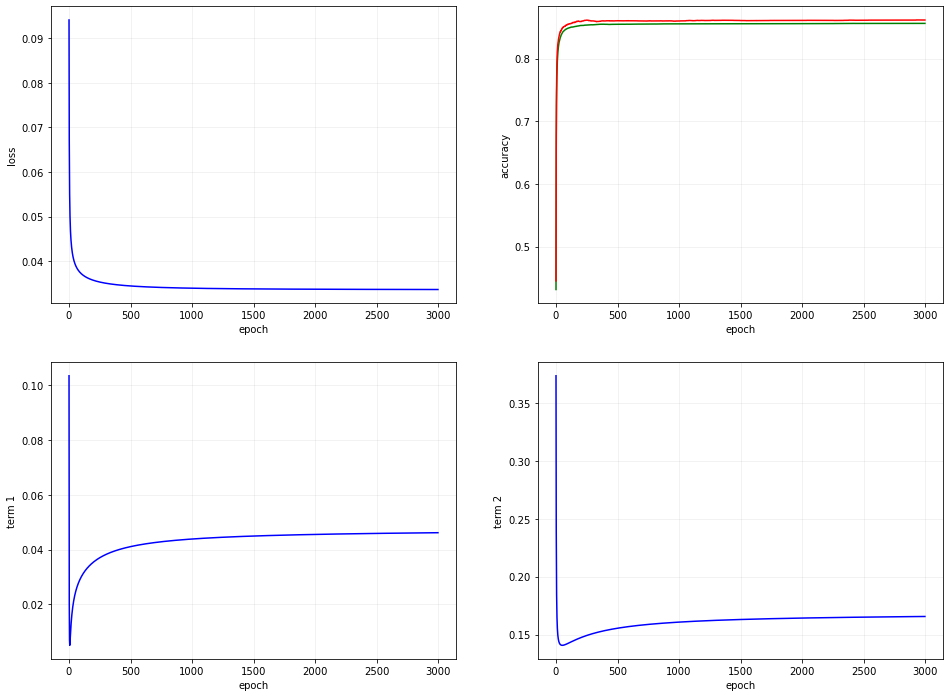

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

axs[0][0].plot(loss_tab, color='blue')
axs[0][1].plot(train_accuracy_tab, color='green')
axs[0][1].plot(test_accuracy_tab, color='red')

axs[1][0].plot(term_I_tab, color = 'blue')
axs[1][1].plot(term_II_tab, color = 'blue')

for row in axs:
    for ax in row:
        ax.grid(True, alpha =0.2)
        ax.set_xlabel('epoch')
        #ax.set_yscale('log')

axs[0][0].set_ylabel('loss')
axs[0][1].set_ylabel('accuracy')
axs[1][0].set_ylabel('term 1')
axs[1][1].set_ylabel('term 2')
plt.show()



## Visualization of mapping of the model

In [9]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(255/256, 1, N)    ## red  255,192, 203
vals[:, 1] = np.linspace(192/256, 1, N)
vals[:, 2] = np.linspace(203/256, 1, N)  ## blue 75, 0, 130
Pinks = ListedColormap(vals)


top = cm.get_cmap(Pinks, 256)
bottom = cm.get_cmap('Purples', 256)

newcolors = np.vstack((top(np.linspace(0, 1, 256)),
                       bottom(np.linspace(0, 1, 256))))

newcmp = ListedColormap(newcolors, name='PinkPueple')

In [10]:
params=[]
for param in model.parameters():
    params.append(param.detach().numpy())
w1=params[0] 
w2=params[1]


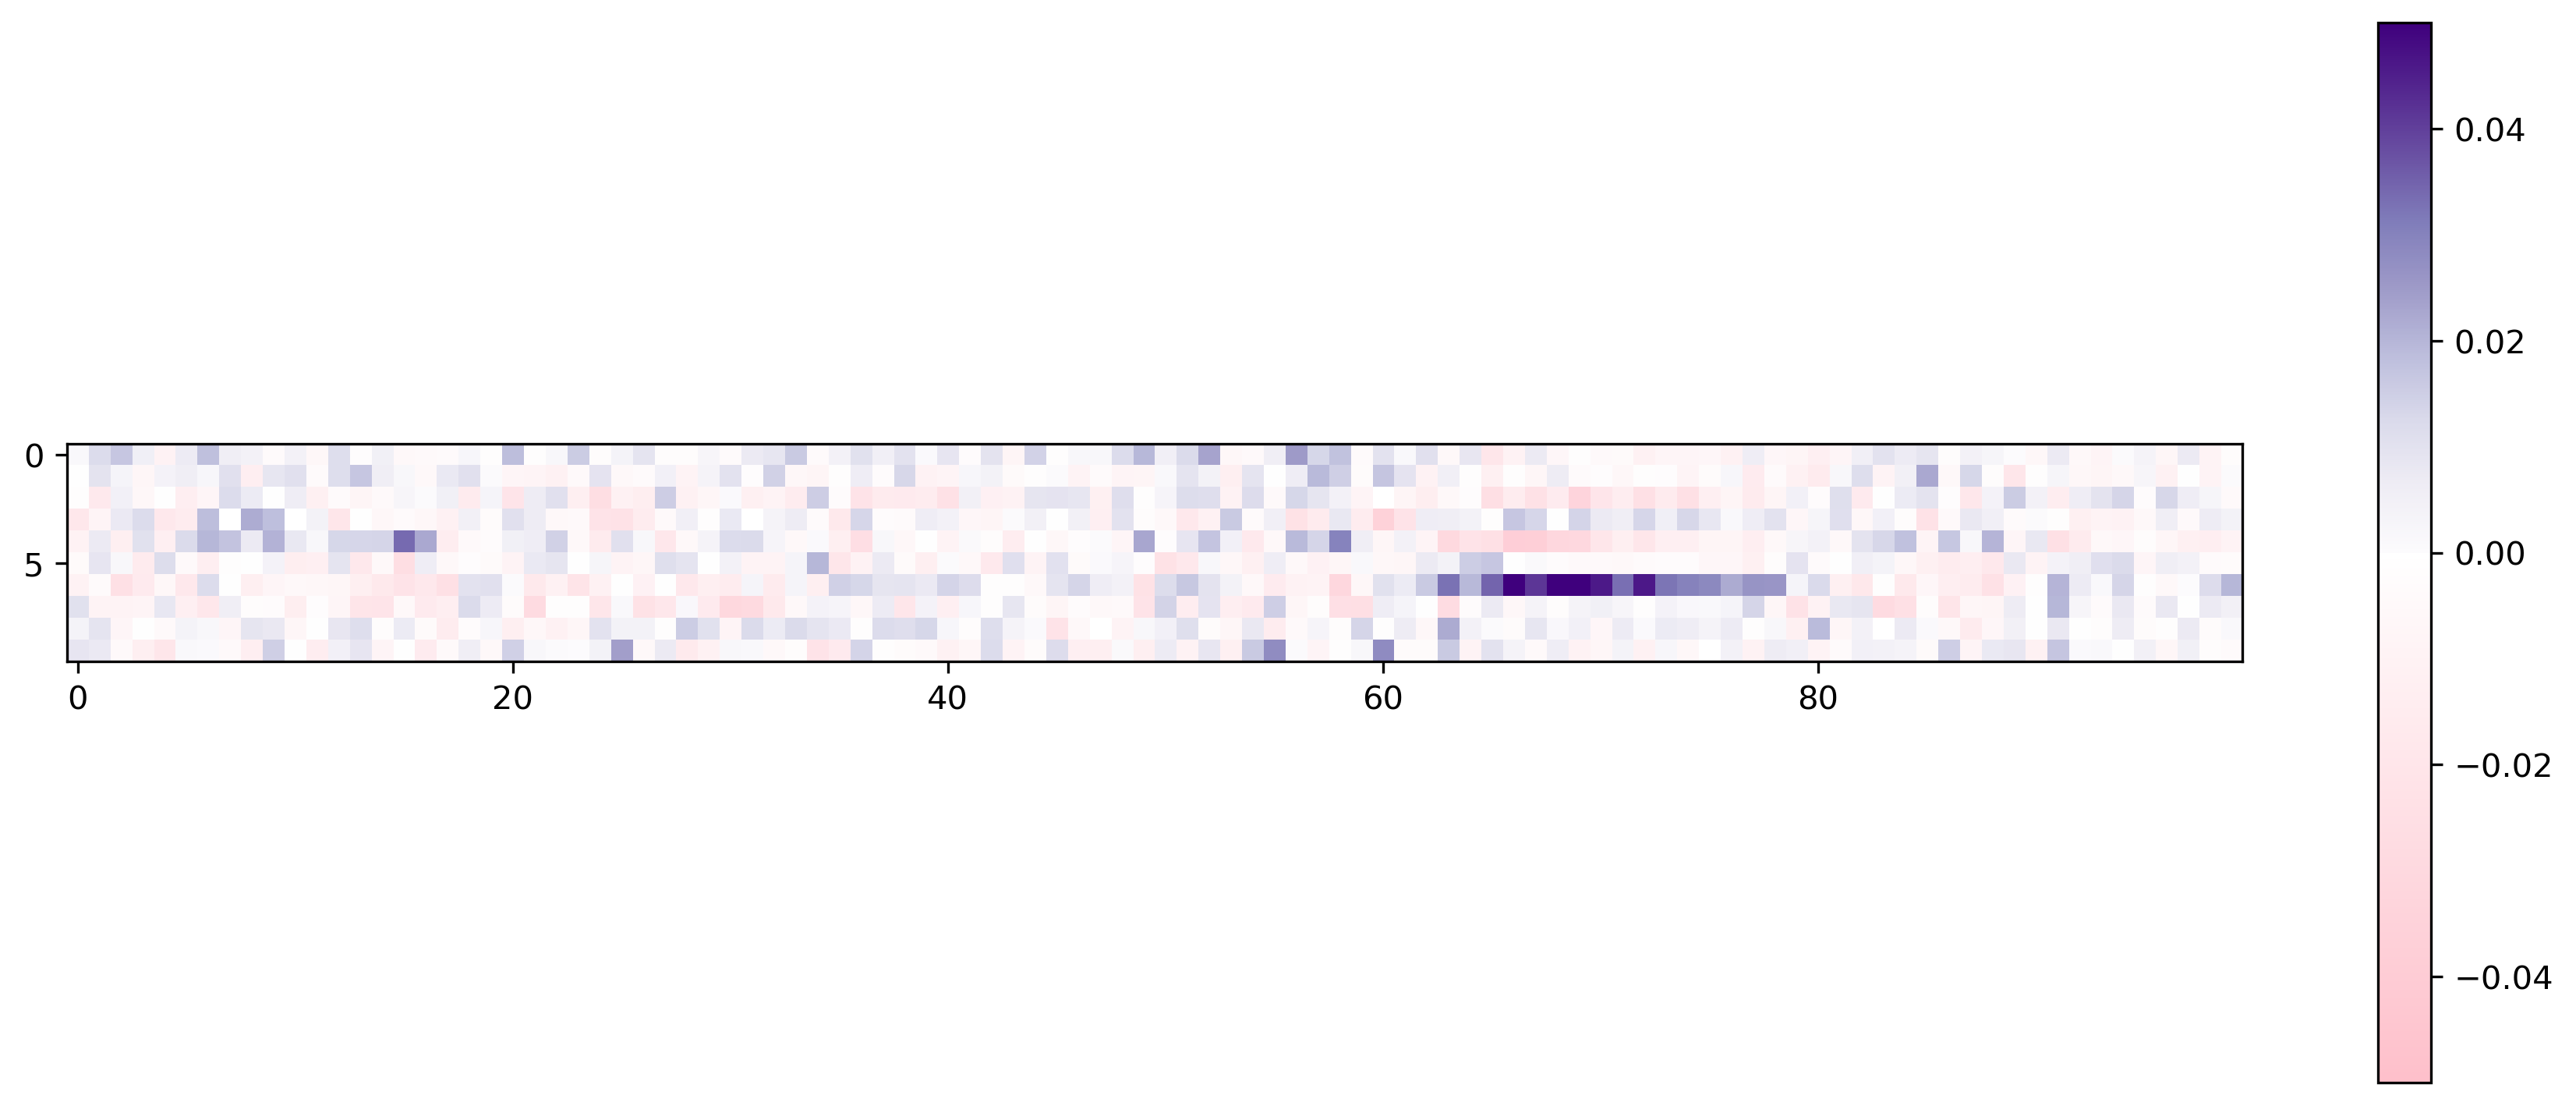

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW =  w2 @ w1 
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


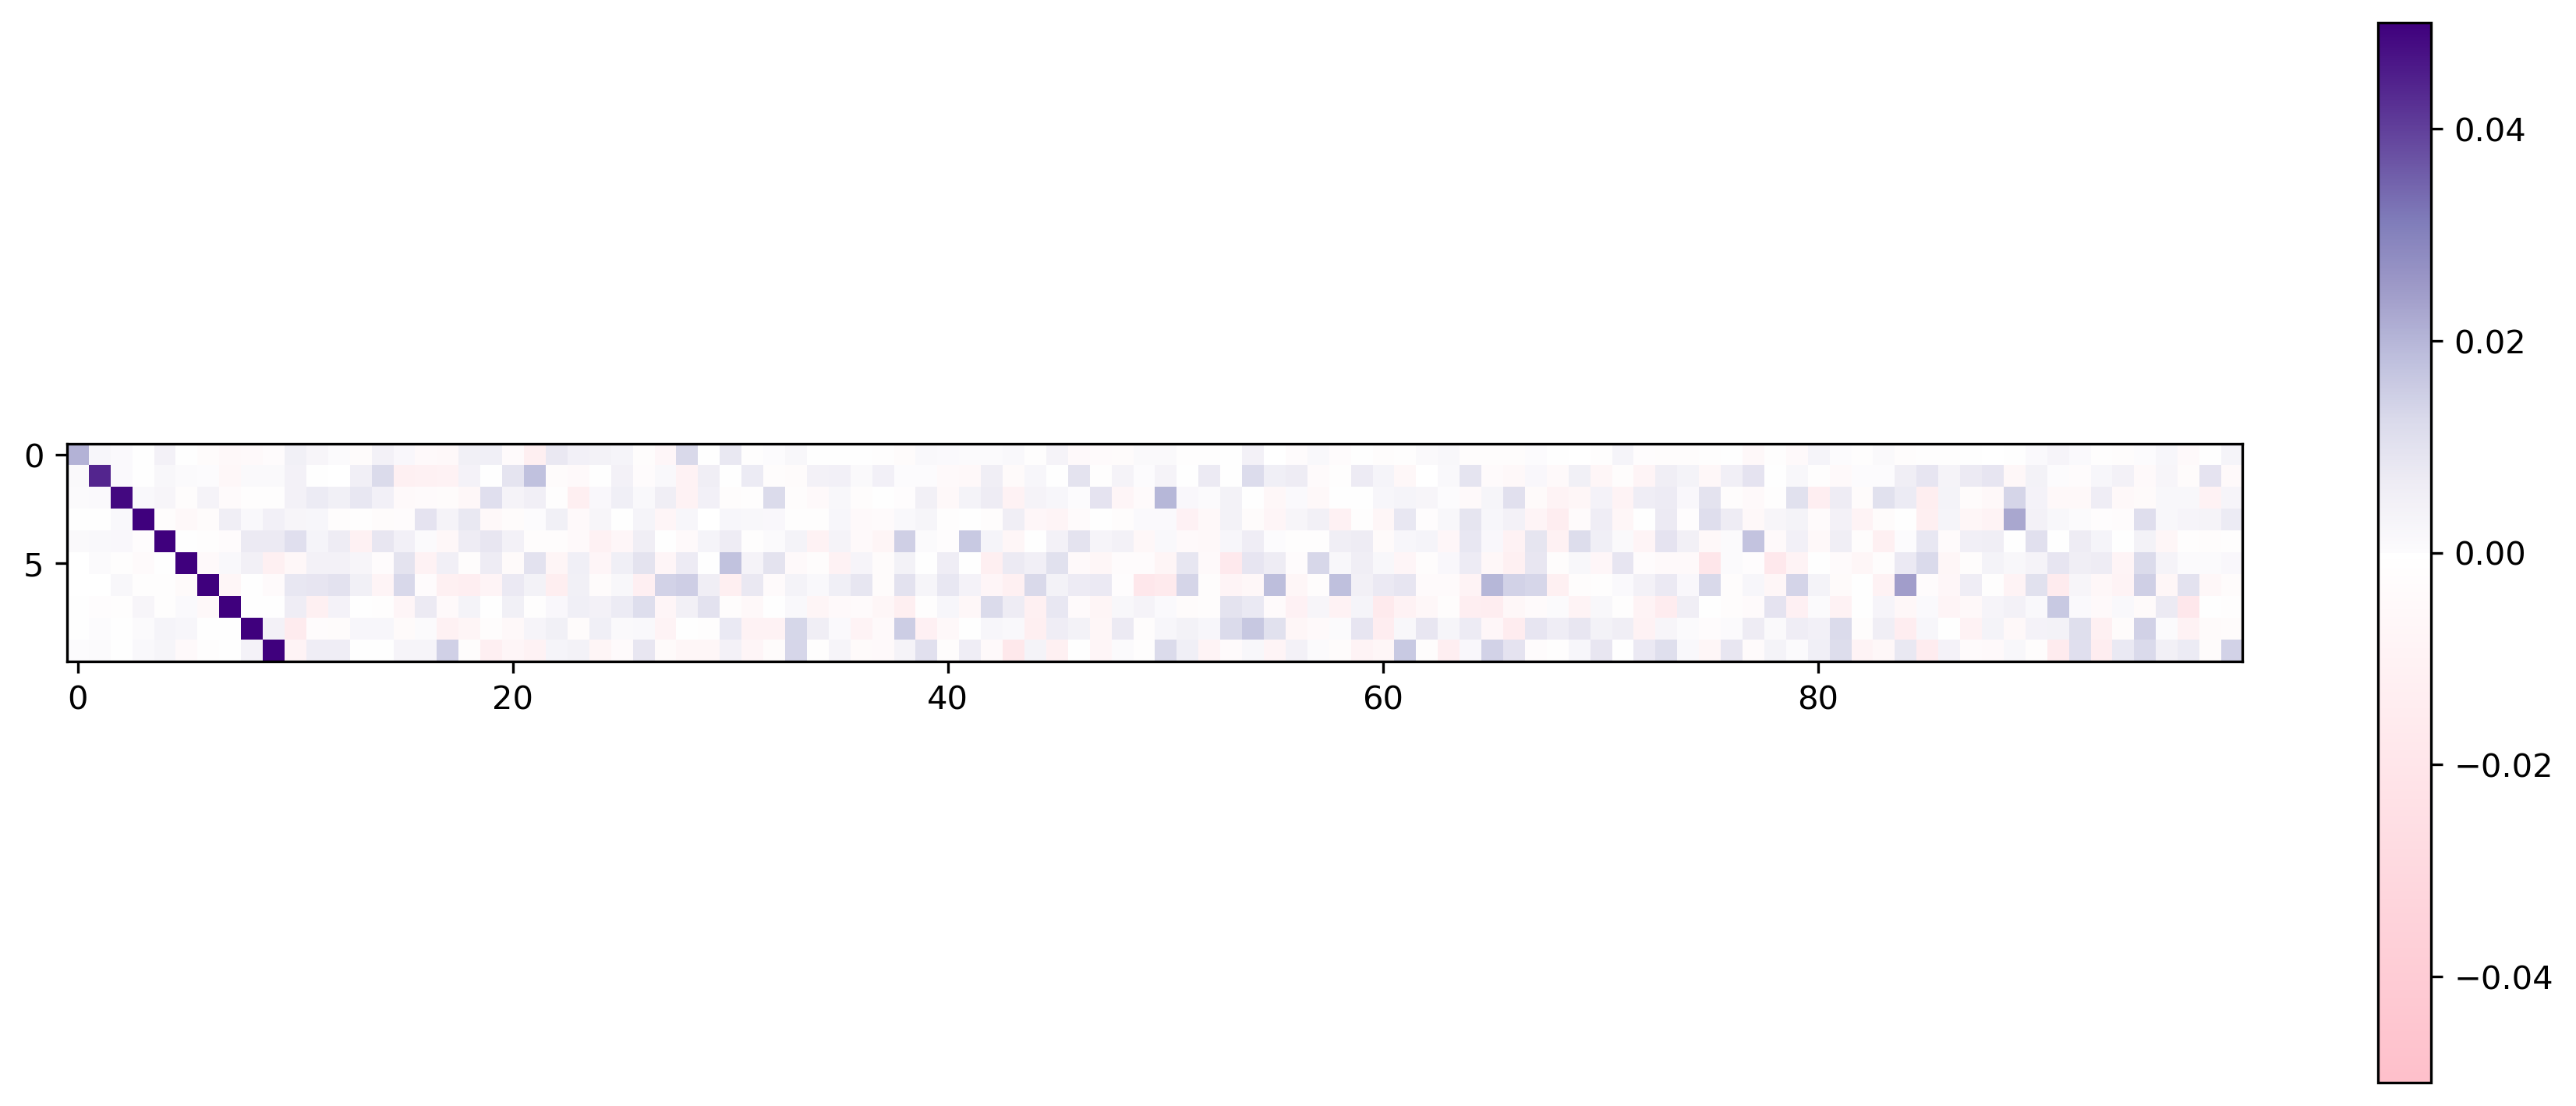

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


CHECK: $$MSE = \frac{1}{P} \sum_{\mu=1}^P \lVert y-\hat{y} \rVert ^2 $$
$$ MSE= \frac{1}{P} \sum_{\mu=1}^P \lVert y - W^2 W^1 x \rVert ^2 $$ 

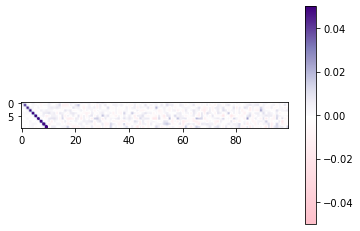

In [13]:
R = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( R[:, :100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

## Calculation of terms

In [14]:
term_1 = 0
for alpha in range(10):
    term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
term_1



array([0.04619818])

In [15]:
term_2 = 0
for beta in range(10):
    for alpha in range(784):
        if(alpha != beta):
            term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
term_2


0.16568121131427982

In [16]:
term_3 = np.trace(S33_matrix)
term_3

1.000000009

In [17]:
term_4 = 0
for alpha in range(10):
    term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]
term_4   

array([0.49717632])

In [18]:
term_1+term_2+term_3-term_4

array([0.71470308])

In [19]:
term_3-term_4

array([0.50282369])

## terms with star: $T_1^*$,  $T_2^*$,  $T_4^*$

In [20]:
term_4 = 0
for alpha in range(10):
    term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
term_4   

0.7852686981379097

In [21]:
term_3-term_4

0.2147313108620904

In [22]:
term_2+term_3-term_4

0.3804125221763702

In [23]:
term_1+term_2+term_3-term_4

array([0.4266107])

# Final MSE on training / testing dataset


In [24]:
MSE_tab=[]
SE_model_tab=[]
SE_calc_tab=[]

batch_size: int = 1  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [25]:
with torch.no_grad():
    for i, (x,y) in enumerate(train_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc = w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on training set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on training set
MSE = 0.038224 	MSE_model = 0.382244	MSEcalc = 0.382244


In [26]:
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc =  w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on test set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on test set
MSE = 0.038232 	MSE_model = 0.382317	MSEcalc = 0.382317


# Save All

In [29]:
import pandas as pd

savefile = 'ground_energy_500.csv'
df = pd.DataFrame()

df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab


df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab
df['R'] = R_tab


df.to_csv(savefile, index=False)

df_w2= pd.DataFrame(np.array(w2_tab).T)
df_w3= pd.DataFrame(np.array(w3_tab).T)

df_w2.to_csv('ground_energy_500_w2.csv', index=False)
df_w3.to_csv('ground_energy_500_w3.csv', index=False)


In [30]:
w1=deepcopy(model.parameters()[0]).detach().numpy().reshape(input_dim*hidden_dim1)
w2=deepcopy(model.parameters()[1]).detach().numpy().reshape(hidden_dim1*output_dim)

df_w1 = pd.DataFrame(w1, columns = ['w1'] )
df_w2 = pd.DataFrame(w2, columns = ['w2'] )

df_w1.to_csv('w1.csv', index=False)
df_w2.to_csv('w2.csv', index=False)
